In [59]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
#from pulser.simulation import Simulation, SimConfig
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform
import networkx as nx
from networkx.algorithms import approximation as approx

# 1.  Five atoms graph

Maximum independent set of G: {1, 3, 4}


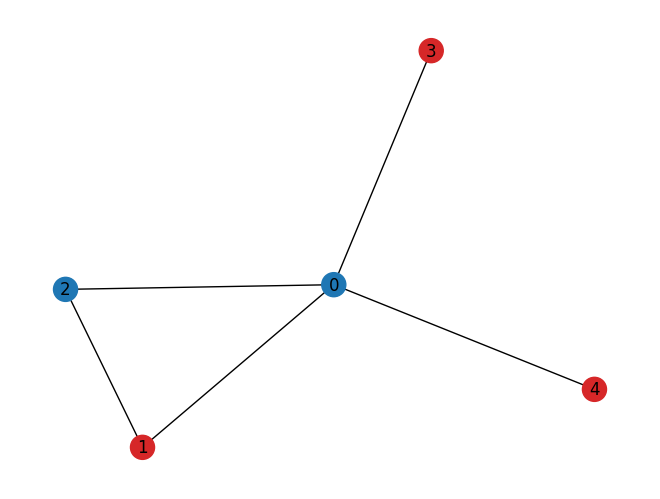

In [15]:
G = nx.Graph(
    [
        (0, 1),
        (0, 2),
        (0, 3),
        (0, 4),
        (1, 2),
    ]
) 

I = approx.maximum_independent_set(G)
print(f"Maximum independent set of G: {I}")

pos = nx.spring_layout(G) #, seed=39299899
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color=["tab:red" if n in I else "tab:blue" for n in G],
)

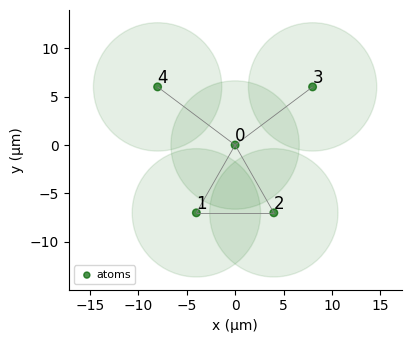

In [7]:
qubits = {'0': (0,0), '1': (-4,-7), '2': (4, -7), '3': (8,6), '4': (-8, 6)}
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

In [8]:
def omega_computation(device, link_max: float, no_link_min: float) -> float:
    """Computation of Omega given the maximum and minimal distances in graph

    Args:
        device: physical device simulation 
        link_max (int): Maximum distances between connect nodes 
        no_link_min (int): Minimal distance between atom that are not connected

    Returns:
        Omega_average (float) 
    """
    
    Omega_min = device.interaction_coeff / no_link_min**6
    Omega_max = device.interaction_coeff / link_max**6
    Omega_average = (Omega_min + Omega_max) / 2
    
    return Omega_average 

In [9]:
def adiabatic_sequence(device, register, time,  Omega = 3.271543 , detuning = 5):
    """Creates the adiabatic sequence

    Args:
        device: physical device simulation 
        Omega
        register: arrangement of atoms in a quantum processor
        time: time of the adiabatic process

    Returns:
        sequence 
    """
    
    delta_0 = -detuning
    delta_f = -delta_0
    
    adiabatic_pulse = Pulse(
    InterpolatedWaveform(time, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(time, [delta_0, 0, delta_f]),
    0,
    )
    
    sequence = Sequence(register, device)
    sequence.declare_channel('ising', 'rydberg_global')
    sequence.add(adiabatic_pulse, 'ising')

    return sequence

In [10]:
def plot_distribution(C):
  C = dict(sorted(C.items(), key = lambda item: item[1], reverse = True))
  #indexes = ['01011', '00111']
  #color_dict = {key: 'r' if key in indexes else 'g' for key in C}
  plt.figure(figsize= (25,6))
  plt.xlabel('bitstings')
  plt.ylabel('counts')
  plt.bar(C.keys(), C.values(), width = 0.5) #, color = color_dict.values()
  plt.xticks(rotation = 'vertical')
  plt.show()

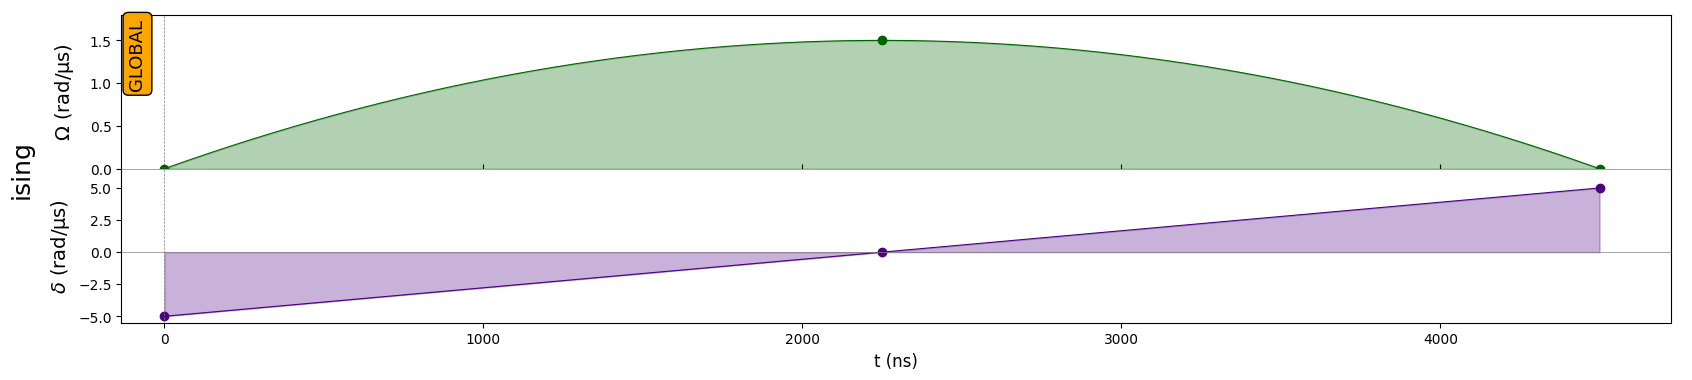

In [12]:
link_max = 10 # Maximum distances between connect nodes (distance betweeen qubit 0 and 4 or 0 and 3)
no_link_min = 13  # Minimal distance between atom that are not connected (distance between atom 2 and 3)

Omega = omega_computation(Chadoq2, link_max, no_link_min)

T = 4500

seq = adiabatic_sequence(Chadoq2,reg, T, Omega = 1.5)

seq.draw()

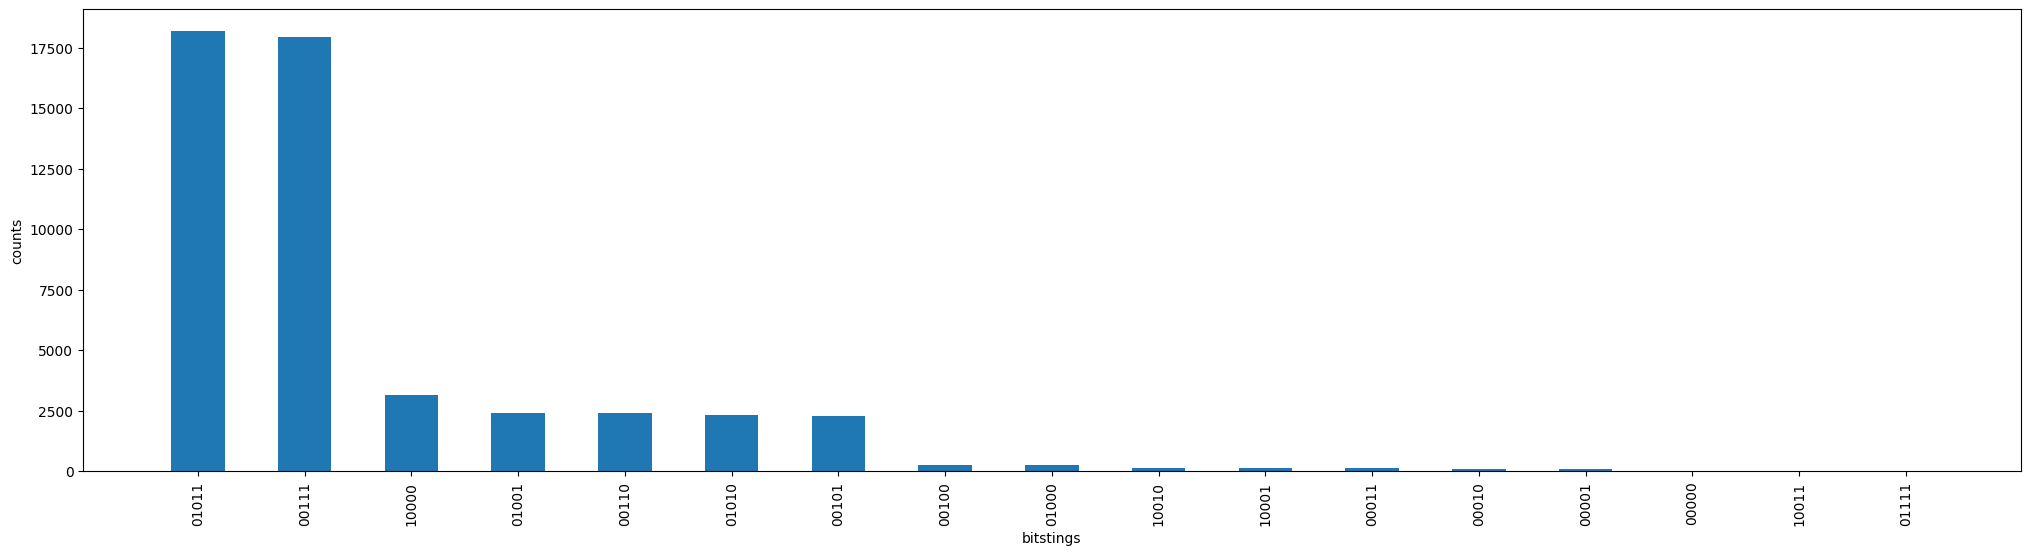

In [14]:
simul = QutipEmulator.from_sequence(seq,sampling_rate=0.1)
results = simul.run()
count_dict = results.sample_final_state(N_samples = 50000)
plot_distribution(count_dict)

# 1.2 Sweeping parameters for the 5 atoms graph

In [18]:
def sweeping_parameters_5_atoms(device, register, omega_sweep = False, detuning_sweep = False):
    """Sweeping over Omega or Detuning parameters for the case of 5 atoms graph

    Args:
        device: physical device simulation 
        register: atoms that define the graph
        omega_sweep: True to iterate over omega parameters
        detuning_sweep: True to iterate over detuning parameters

    Returns:
        success_probability_for_plot: Probability of correct ansewer given the omega and detuning parameters
        time_parameters: time use in the adibatic process
        parameters: the omega or detuning parmeters used 
    """
    
    success_probability_for_plot=[]
    time_parameters = 1000 * np.linspace(1, 10, 10)
    samples = 10000
    
    if omega_sweep == True: 
        parameters = np.linspace(1, 10, 30)
    if detuning_sweep == True:
        parameters = np.linspace(1, 30, 30)
        
    
    for T in time_parameters:
        success_probability=[]
        for par in parameters:
            if omega_sweep == True: 
                seq = adiabatic_sequence(device, register, T, Omega = par)
            if detuning_sweep == True:
                seq = adiabatic_sequence(device, register, T, detuning = par)
            simul = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
            results = simul.run(progress_bar=False)
            count_dict = results.sample_final_state(N_samples = samples) 
            success_probability.append((count_dict['01011'] + count_dict['00111'])/samples)
        success_probability_for_plot.append(success_probability)
        
    return success_probability_for_plot, time_parameters, parameters

## Sweeping Omega parameters for the 5 atoms graph

In [19]:
success_probs_for_plot_omega_sweep, times, omegas = sweeping_parameters_5_atoms(Chadoq2, reg,  omega_sweep = True)

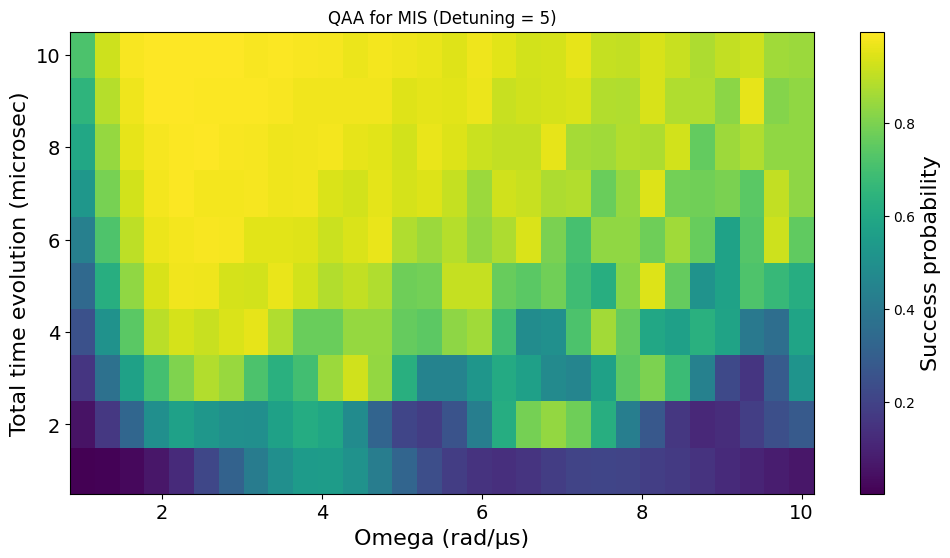

In [20]:
x=np.array(omegas)
y=np.array(times)/1000
X,Y = np.meshgrid(x,y)

Z= np.array(success_probs_for_plot_omega_sweep)

plt.figure(figsize=(12,6))
plt.pcolormesh(X,Y,Z)
plt.title('QAA for MIS (Detuning = 5)')
plt.ylabel('Total time evolution (microsec)', fontsize = 16)
plt.xlabel('Omega (rad/µs)', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

cbar = plt.colorbar() 
cbar.set_label('Success probability', fontsize = 16)

#plt.savefig('qaa_test_omega.png')

plt.show()

## Sweeping detuning parameters for the 5 atoms graph

In [53]:
success_probs_for_plot_detuning_sweep_5_atoms, times_5_atoms, detuning_5_atoms = sweeping_parameters_5_atoms(Chadoq2, reg,  detuning_sweep = True)

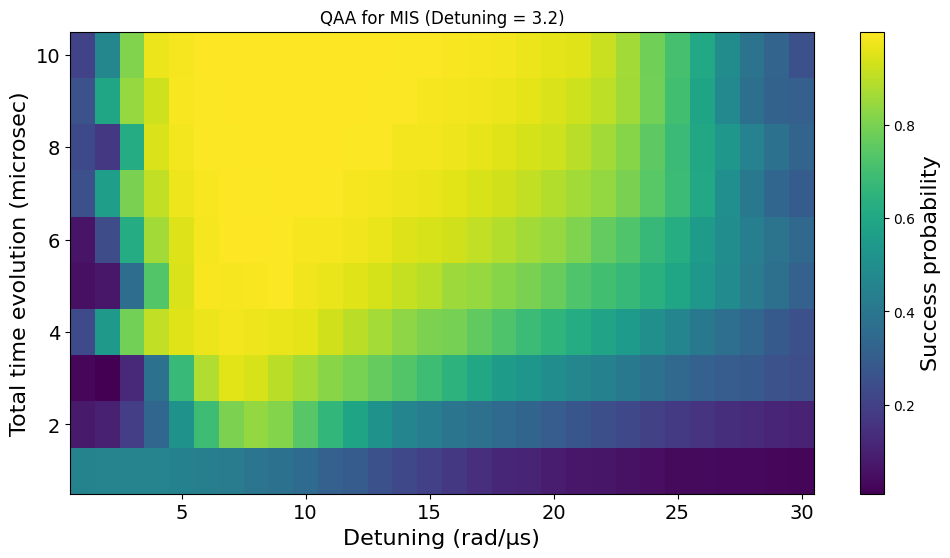

In [57]:
x=np.array(detuning_5_atoms)
y=np.array(times_5_atoms)/1000
X,Y = np.meshgrid(x,y)

Z= np.array(success_probs_for_plot_detuning_sweep_5_atoms)

plt.figure(figsize=(12,6))
plt.pcolormesh(X,Y,Z)
plt.title('QAA for MIS (Detuning = 3.2)')
plt.ylabel('Total time evolution (microsec)', fontsize = 16)
plt.xlabel('Detuning (rad/µs)', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

cbar = plt.colorbar() 
cbar.set_label('Success probability', fontsize = 16)

#plt.savefig('qaa_test_omega.png')

plt.show()

# 2. 8 atoms graph 

Maximum independent set of G: {3, 4, 5, 6}


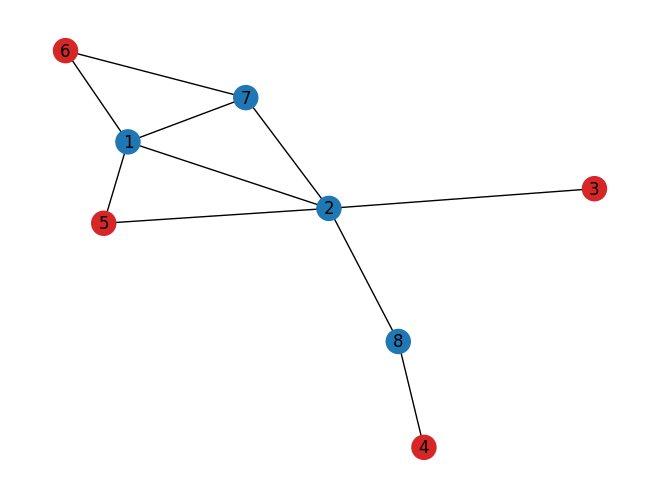

In [27]:
G = nx.Graph(
    [
        (1, 2),
        (7, 2),
        (3, 2),
        (7, 6),
        (5, 2),
        (1, 5),
        (2, 8),
        (1, 7),
        (6, 1),
        (8, 4),
    ]
)

I = approx.maximum_independent_set(G)
print(f"Maximum independent set of G: {I}")

pos = nx.spring_layout(G, seed=39299899)
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color=["tab:red" if n in I else "tab:blue" for n in G],
)

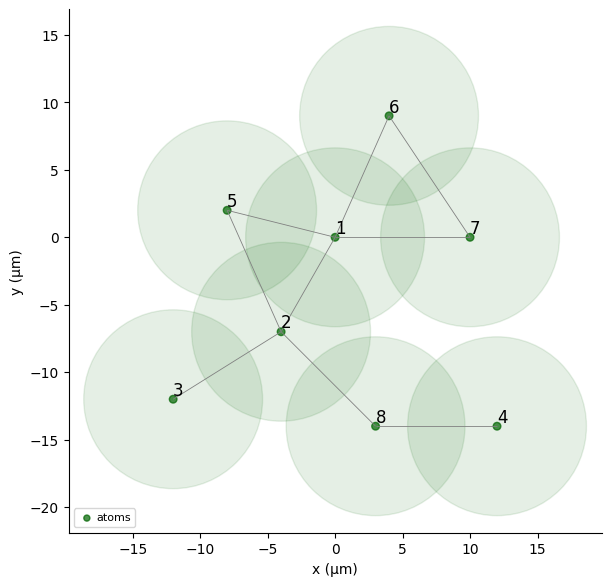

In [28]:
qubits = {'1': (0,0), '2': (-4,-7), '3': (-12, -12), '4': (12,-14), '5': (-8, 2),  '6': (4,9), '7': (10,0), '8': (3,-14)}
reg2 = Register(qubits) 
reg2.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

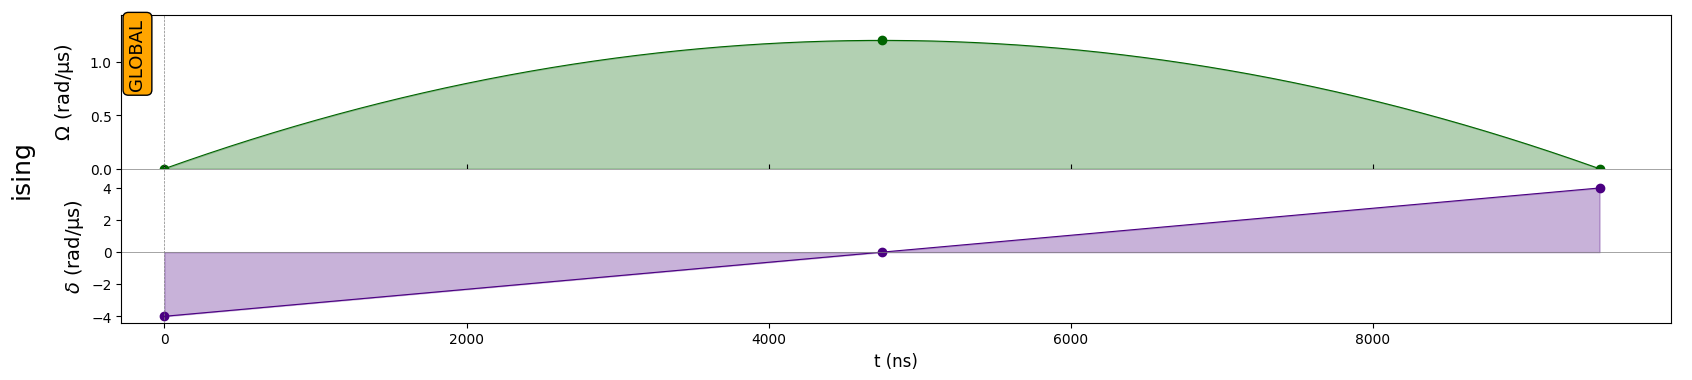

In [31]:
#link_max = 10 # Maximum distances between connect nodes (distance betweeen qubit 0 and 4 or 0 and 3)
#no_link_min = 13  # Minimal distance between atom that are not connected (distance between atom 2 and 3)

#Omega = omega_computation(Chadoq2, link_max, no_link_min)
T = 9500

seq = adiabatic_sequence(Chadoq2,reg2, T, Omega = 1.2,  detuning = 4)

seq.draw()

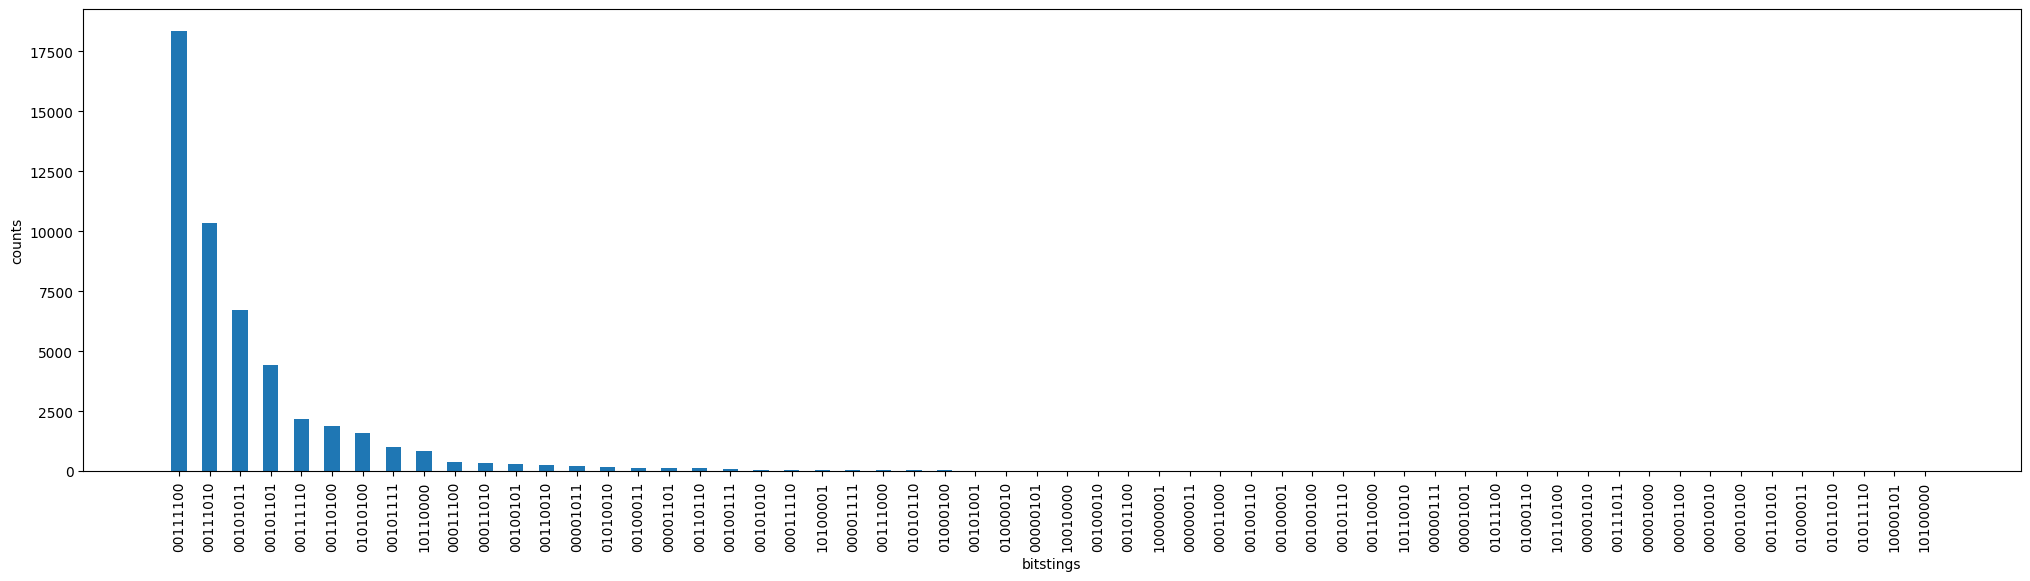

In [32]:
simul = QutipEmulator.from_sequence(seq,sampling_rate=0.1)
results = simul.run()
count_dict = results.sample_final_state(N_samples = 50000)
plot_distribution(count_dict)

# 2.1 Sweeping parameters for the 8 atoms graph

In [50]:
def sweeping_parameters_8_atoms(device, register, omega_sweep = False, detuning_sweep = False):
    """Sweeping over Omega or Detuning parameters for the case of 8 atoms graph

    Args:
        device: physical device simulation 
        register: atoms that define the graph
        omega_sweep: True to iterate over omega parameters
        detuning_sweep: True to iterate over detuning parameters

    Returns:
        success_probability_for_plot: Probability of correct ansewer given the omega and detuning parameters
        time_parameters: time use in the adibatic process
        parameters: the omega or detuning parmeters used 
    """
    
    success_probability_for_plot=[]
    time_parameters = 1000 * np.linspace(1, 35, 35)
    samples = 10000
    
    if omega_sweep == True: 
        parameters = np.linspace(1, 5, 5)
    if detuning_sweep == True:
        parameters = np.linspace(1, 5, 10)
        
    
    for T in time_parameters:
        success_probability=[]
        for par in parameters:
            if omega_sweep == True: 
                seq = adiabatic_sequence(device, register, T, Omega = par, detuning = 3)
            if detuning_sweep == True:
                seq = adiabatic_sequence(device, register, T, Omega = 1, detuning = par)
            simul = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
            results = simul.run(progress_bar=False)
            count_dict = results.sample_final_state(N_samples = samples) 
            success_probability.append((count_dict['00111100'] + count_dict['00111010'])/samples)
        success_probability_for_plot.append(success_probability)
        
    return success_probability_for_plot, time_parameters, parameters

## Sweeping Omega parameters for the 8 atoms graph

In [47]:
success_probs_for_plot_omega_sweep_8_atoms, times_8_atoms, omegas_8_atoms = sweeping_parameters_8_atoms(Chadoq2, reg2,  omega_sweep = True)

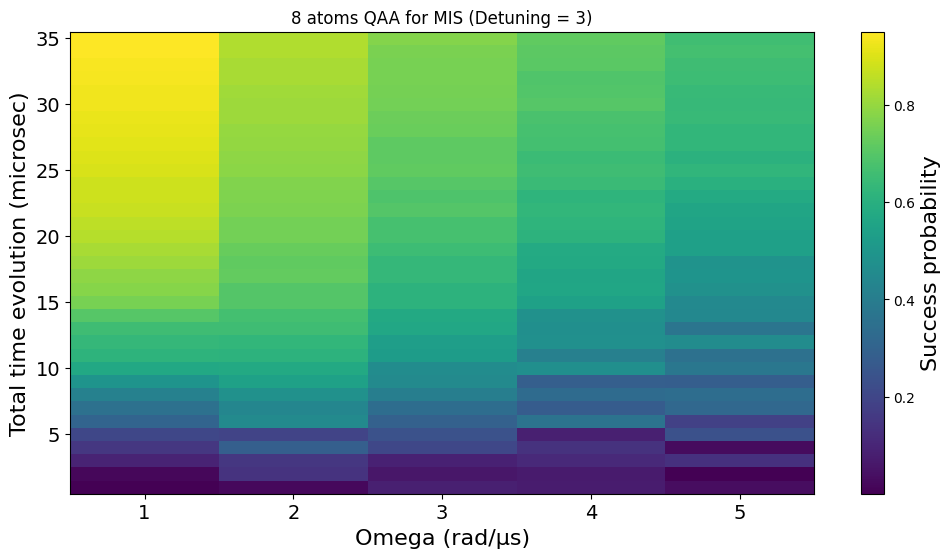

In [49]:
x=np.array(omegas_8_atoms)
y=np.array(times_8_atoms)/1000
X,Y = np.meshgrid(x,y)

Z= np.array(success_probs_for_plot_omega_sweep_8_atoms)

plt.figure(figsize=(12,6))
plt.pcolormesh(X,Y,Z)
plt.title('8 atoms QAA for MIS (Detuning = 3)')
plt.ylabel('Total time evolution (microsec)', fontsize = 16)
plt.xlabel('Omega (rad/µs)', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

cbar = plt.colorbar() 
cbar.set_label('Success probability', fontsize = 16)

#plt.savefig('qaa_test_omega.png')

plt.show()

## Sweeping detuning parameters for the 8 atoms graph

In [51]:
success_probs_for_plot_detuning_sweep_8_atoms, times_8_atoms, detunings_8_atoms = sweeping_parameters_8_atoms(Chadoq2, reg2,  detuning_sweep = True)

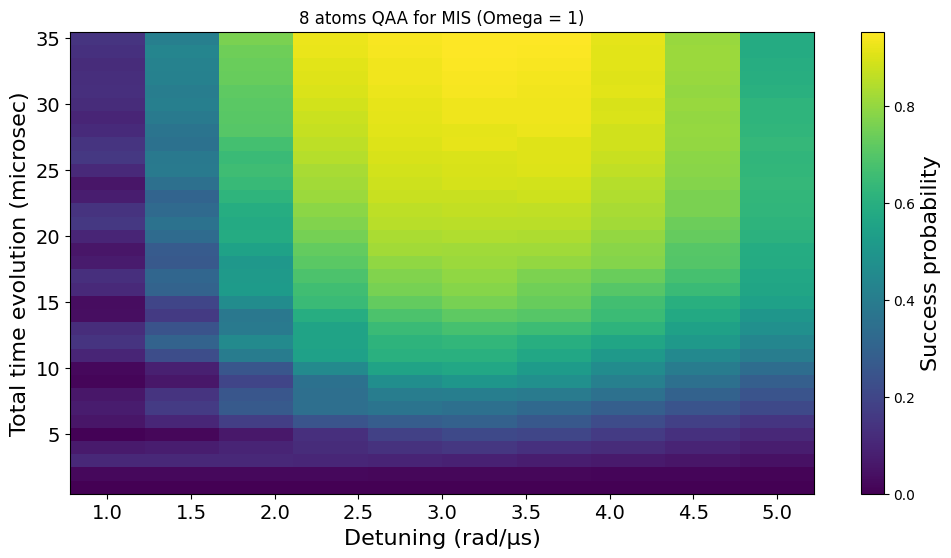

In [52]:
x=np.array(detunings_8_atoms)
y=np.array(times_8_atoms)/1000
X,Y = np.meshgrid(x,y)


Z= np.array(success_probs_for_plot_detuning_sweep_8_atoms)

plt.figure(figsize=(12,6))
plt.pcolormesh(X,Y,Z)
plt.title('8 atoms QAA for MIS (Omega = 1)')
plt.ylabel('Total time evolution (microsec)', fontsize = 16)
plt.xlabel('Detuning (rad/µs)', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

cbar = plt.colorbar() 
cbar.set_label('Success probability', fontsize = 16)

#plt.savefig('qaa_test_detuning.png')

plt.show()